# Learning Image Captions with CNNs and LSTMs

Please note that I've provided *restoration points* for this notebook because this model can take long to run. So if you happen to close the notebook just before a restoration point, you can start from the restoration point next time you open the notebook :)

## Restoration Points
* [RESTORATION POINT: Loading Previously Computed Data](#RESTORATION-POINT:-Loading-Previously-Computed-Data)
* [RESTORATION POINT: Load Numerical Captions from Disk](#RESTORATION-POINT:-Load-Numerical-Captions-from-Disk)

In [1]:
# These are all the modules that will be used.Please make sure you can import them
# before proceeding further.
from __future__ import print_function
%matplotlib inline

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import nltk
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from PIL import Image
import json
import pickle
from nltk.translate import bleu_score
import csv

# I have isolated word vector learning related things 
# in the following script, to avoid clutter.
import word2vec

## Downloading and Preparing MSCOCO Dataset

Download the datasets from http://cocodataset.org/#download. Next we need to create a specific folder structure and place downloaded files correctly, so that the algorithm can retrieve necessary files.

* Folder Creation
 * Create a folder `image_caption_data` inside the img_gen folder (i.e. `img_gen/image_caption_data`)
 * Create a folder `train_valid` within `image_caption_data` folder
 * Create two folders `images` and `annotations` folders within the `train_valid` folder
* Training and Validation set (`val2014.zip`, `annotations_trainval2014.zip`): 2014 Validation set (approximately 41,000 data points (6GB))
 * Download the zip file (`val2014.zip`) and copy it to `image_caption_data/train/images` folder
 * Download the zip file (`annotations_trainval2014.zip`) and copy the content to `image_caption_data/train/annotations` folder

We will use the first 1000 images as the validation set and rest as the training set


## Convolution Neural Network for Obtaining Image Encodings

Here I first define the implementation related to the CNN I used to generate image encodings. First we define a set of TensorFlow variables and load the downloaded pretrained weights to the variables. Then we define a input reading and preprocessing pipeline, through which the CNN will get its inputs. Next we define the inference (that is, model prediction) logic for the CNN to get the image feature vectors. Finally we write a piece of code to run the inference logic on all the MS-COCO images and save the image encodings as JSON files.

I've tried to make the code easy to follow, but if there are any questions or comments please feel free to comment!

### Defining Constants
First I defined the various constants. All the strings defined here are used to name the variables in TensorFlow. We also need to keep track of where the pooling layers are in the original network......

In [2]:
TF_WEIGHTS_STR = 'weights' # Used for weight related TensorFlow variables
TF_BIAS_STR = 'bias' # Used for bias related TensorFlow variables

# Represent the different layers of the CNN
TF_SCOPES = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2','conv3_3',
             'conv4_1','conv4_2','conv4_3','conv5_1','conv5_2','conv5_3',
             'fc6','fc7','fc8']

# Where we need to insert max pool layers
MAX_POOL_INDICES = [1,3,6,9,12]

### Session Configuration
Some session configuration such as how much max memory is allocated for the task. This was something I learnt while doing this project, after a number of system crashes and lots of crying...
Here's a link to learn more about this :https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory

In [3]:
# Some of the configuration settings we use when creating the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.allow_soft_placement=True

### Loading Class Names of Classes of the ImageNet Dataset
Now to see if the network is fuctioning properly,I wanted to check if the images are classified correctly. To ensure that, we need to know what classes we have in our CNN. This loads that list of classes as a Python list

In [4]:
with open(os.path.join('image_caption_data','class_names.txt'),'r') as f:
    class_names = f.readlines()

for c_i in range(len(class_names)):
    class_names[c_i] = class_names[c_i][:-1]
    
print(class_names[:10])


['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus']


### Defining VGG Variables and Initialization
Here we write a function to define TensorFlow variables and assign the corresponding numpy array weight as the initializer.

In [5]:
def build_vgg_variables(npz_weights):
    '''
    Build the required tensorflow variables to populate the VGG-16 model
    and populate them with actual weights
    :param npz_weights: loaded weights as a dictionary
    :return:
    '''

    params = []
    print("Building VGG Variables (Tensorflow)...")

    with tf.variable_scope('CNN'):
        # Iterate through each convolution and fully connected layer
        # and create TensorFlow variables using variable scoping
        for si,scope in enumerate(TF_SCOPES):
            with tf.variable_scope(scope) as sc:
                weight_key, bias_key = TF_SCOPES[si]+'_W', TF_SCOPES[si]+'_b'

                with tf.device('/cpu:0'):
                    weights = tf.get_variable(TF_WEIGHTS_STR,
                                              initializer= npz_weights[weight_key])
                    bias = tf.get_variable(TF_BIAS_STR,
                                           initializer = npz_weights[bias_key])

                    params.extend([weights,bias])

    return params

### Running VGG Variable Initialization
Here we first need to download the [VGG network weights](http://www.cs.toronto.edu/~frossard/post/vgg16/) and place the file in the `image_caption_data` folder. Then we can run the above define function to initialize the variables properly. Note that the weights file is around ~600MB so it might take a while to download.

In [6]:
# Load the weights downloaded from http://www.cs.toronto.edu/~frossard/post/vgg16/
weight_file = os.path.join('image_caption_data', 'vgg16_weights.npz')
weights = np.load(weight_file)
# Get the layer identifiers
keys = sorted(weights.keys())

var_shapes = {}

# Here we print the sizes of the variables 
# as well as add that to a dictionary
# to make sure it is the correct network we're looking for
print('Printing Information about Available weights...')
for i, k in enumerate(keys):
    print('\tKey ID: %d, Key: %s, Weight shape: %s'%(i, k, list(np.shape(weights[k]))))
    var_shapes[k] = list(np.shape(weights[k]))
print('')

print('Variable shapes dictionary')
print('\t%s\n'%var_shapes)

# Initialize the variables
params = build_vgg_variables(weights)

# Create a session
sess = tf.InteractiveSession(config=config)


Printing Information about Available weights...
	Key ID: 0, Key: conv1_1_W, Weight shape: [3, 3, 3, 64]
	Key ID: 1, Key: conv1_1_b, Weight shape: [64]
	Key ID: 2, Key: conv1_2_W, Weight shape: [3, 3, 64, 64]
	Key ID: 3, Key: conv1_2_b, Weight shape: [64]
	Key ID: 4, Key: conv2_1_W, Weight shape: [3, 3, 64, 128]
	Key ID: 5, Key: conv2_1_b, Weight shape: [128]
	Key ID: 6, Key: conv2_2_W, Weight shape: [3, 3, 128, 128]
	Key ID: 7, Key: conv2_2_b, Weight shape: [128]
	Key ID: 8, Key: conv3_1_W, Weight shape: [3, 3, 128, 256]
	Key ID: 9, Key: conv3_1_b, Weight shape: [256]
	Key ID: 10, Key: conv3_2_W, Weight shape: [3, 3, 256, 256]
	Key ID: 11, Key: conv3_2_b, Weight shape: [256]
	Key ID: 12, Key: conv3_3_W, Weight shape: [3, 3, 256, 256]
	Key ID: 13, Key: conv3_3_b, Weight shape: [256]
	Key ID: 14, Key: conv4_1_W, Weight shape: [3, 3, 256, 512]
	Key ID: 15, Key: conv4_1_b, Weight shape: [512]
	Key ID: 16, Key: conv4_2_W, Weight shape: [3, 3, 512, 512]
	Key ID: 17, Key: conv4_2_b, Weight sh

### Defining the TensorFlow Input Pipeline 

With the CNN initialization logic written,I can now define input reading and preprocessing code...

* Read invidual JPEG files
* Then decode the JPEG files to read the data
* Resize the images to `224x224x3`(deafult input size for the VGG16 model)
* Make the inputs zero-mean
* Finally get a batch of the read and preprocessed images

In [7]:
def preprocess_inputs_with_tfqueue(filenames, batch_size):
    '''
    An advance input pipeline implemented with tensorflow. 
    
    :param filenames: filenames
    :param batch_size: the size of a single batch that should be returned
    :return: an image batch
    '''
    
    # Print some filenames to make sure we're reading data correctly
    print('Received filenames: ',filenames[:10])
    
    with tf.name_scope('Preprocess'):
        # FIFO(First in First out) queue of file names
        # creates a FIFO queue until the reader needs them
        filename_queue = tf.train.string_input_producer(filenames, capacity=10, shuffle=False)

        # Reader which takes a filename queue and read() which outputs data one by one
        reader = tf.WholeFileReader()
        _, image_buffer = reader.read(filename_queue, name='image_read_op')

        # Read the raw image data and return as uint8
        dec_image = tf.image.decode_jpeg(contents=image_buffer,channels=3,name='decode_jpg')
        # Convert uint8 data to float32
        float_image = tf.image.convert_image_dtype(dec_image,dtype=tf.float32,name= 'float_image')
        # Resize image to 224x224x3
        resized_image = tf.image.resize_images(float_image,[224,224])*255.0

        # For VGG, images are only zero-meaned (not standardized to unit variance)
        std_image = resized_image - tf.reduce_mean(resized_image,axis=[0,1], keepdims=True)

        # The batching mechanism that takes a output produced by reader (with preprocessing) and outputs a batch tensor
        # [batch_size, height, width, depth] 4D tensor
        image_batch = tf.train.batch([std_image], batch_size = batch_size, capacity = 10, 
                                     allow_smaller_final_batch=False, name='image_batch')

    print('Preprocessing done\n')
    return image_batch


### TensorFlow Operations for Inferring with VGG-16 CNN

Next up is the forward propagation (or inference) logic of the CNN. I wrote a function that takes in a batch of inputs (which is returned by the function I defined above) and calculates the hidden output iteratively for each scope (or layer id) that I have in `TF_SCOPES` iteratively. Finally it outputs the last layer output, without passing it through an activation function.

In [8]:
def inference_cnn(tf_inputs, device):
    '''
    Inferencing the CNN model. The input (tf_inputs) is propagated through convolutions poolings
    fully-connected layers to obtain the final softmax output
    :param tf_inputs: A batch of images (tensorflow placeholder)
    :return: The final layer output (without activation)
    '''
    with tf.device(device):
        with tf.variable_scope('CNN'):
            for si, scope in enumerate(TF_SCOPES):
                with tf.variable_scope(scope,reuse=True) as sc:
                    weight, bias = tf.get_variable(TF_WEIGHTS_STR), tf.get_variable(TF_BIAS_STR)

                    # Each convolution layer operations
                    if 'fc' not in scope:
                        if si == 0:
                            h = tf.nn.relu(tf.nn.conv2d(tf_inputs,weight,strides=[1,1,1,1],padding='SAME')+bias)
                        else:
                            h = tf.nn.relu(tf.nn.conv2d(h, weight, strides=[1, 1, 1, 1], padding='SAME') + bias)
                    # Each fully connected layer operations
                    else:
                        # Reshaping required for the first fulcon layer which is fc6
                        if scope == 'fc6':
                            h_shape = h.get_shape().as_list()
                            h = tf.reshape(h,[h_shape[0], h_shape[1] * h_shape[2] * h_shape[3]])

                        if scope == 'fc8':
                            out = tf.matmul(h,weight) + bias
                        else:
                            h = tf.nn.relu(tf.matmul(h, weight) + bias)

                    # Max pooling operation at each max-pooling index
                    if si in MAX_POOL_INDICES:
                        h = tf.nn.max_pool(h,[1,2,2,1],[1,2,2,1],padding='SAME')

    return out

### Loading the MS-COCO Images 

The next step is to infer the pretrained CNN with the MS-COCO images saved earlier, located in the `image_caption_data/train_valid/images` folder. To avoid any system crashes, set the device for processing this data to CPU. However, if you have a big enough GPU (say > 8GB) feel free to use `/gpu:<gpu_id>`.This process WILL take some time. I learnt this while running this notebook on my old NVIDIA GTX 970M, and then later running it on the RTX 2080. For the former, changing it to CPU was working but taking considerably longer. 

In [9]:
# Note that if you use GPU without enough memory, the program might crash. 
# Running on the CPU will avoid any crashes, but at the same time will increase the computational time
device = '/gpu:0' 

# Where the image data is
image_file_dir = os.path.join('image_caption_data', *('train_valid','images'))
# Creates a list with all the files found in the directory
image_filenames = [os.path.join(image_file_dir,f) for f in os.listdir(image_file_dir) if os.path.isfile(os.path.join(image_file_dir, f)) and f.endswith('.jpg')]

# Separating training and validation data
# Training data all the images except first 1000
train_image_filenames = image_filenames[1000:] 
# Validation/Testing data: the first 1000 images
test_image_filenames = image_filenames[:1000] 

# I set the batch size to 10
# Be careful if you're increasing this
# It can result in a crash
batch_size = 5

print('Defining reading and preprocessing data ..')
# Processing training images
train_image_batch = preprocess_inputs_with_tfqueue(train_image_filenames,batch_size)

# Processing testing images
test_image_batch = preprocess_inputs_with_tfqueue(test_image_filenames,batch_size)

print('Defining CNN inference operations')
# Get image encodings for training data
tf_train_logit_prediction = inference_cnn(train_image_batch,device)
# Get image encodings for testing data
tf_test_logit_prediction = inference_cnn(test_image_batch,device)

print('Defining CNN prediction operations')
# Get predictions for training data
tf_train_softmax_prediction = tf.nn.softmax(tf_train_logit_prediction)
# Get predictions for testing data
tf_test_softmax_prediction = tf.nn.softmax(tf_test_logit_prediction)

print('\tDone')

W0903 13:25:25.500761 31084 deprecation.py:323] From <ipython-input-7-a8548f45d021>:16: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0903 13:25:25.680280 31084 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\input.py:278: input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Defining reading and preprocessing data ..
Received filenames:  ['image_caption_data\\train_valid\\images\\COCO_val2014_000000014248.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014257.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014265.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014271.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014276.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014278.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014282.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014285.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014297.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000014306.jpg']


W0903 13:25:25.681277 31084 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\input.py:190: limit_epochs (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
W0903 13:25:25.683272 31084 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\input.py:199: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0903 13:25:25.685267 31084 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\input.py:199: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated 

Preprocessing done

Received filenames:  ['image_caption_data\\train_valid\\images\\COCO_val2014_000000000042.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000073.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000074.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000133.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000136.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000139.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000143.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000164.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000192.jpg', 'image_caption_data\\train_valid\\images\\COCO_val2014_000000000196.jpg']
Preprocessing done

Defining CNN inference operations
Defining CNN prediction operations
	Done


### Checking if Images Actually Exist lol
Check if images are okay by visualizing an image with matplotlib...in case they aren't and you spend hours figuring out what's wrong :)

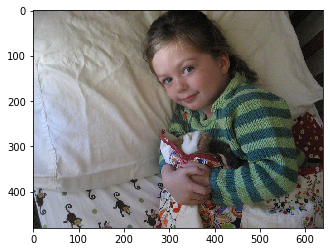

In [10]:
img_data = Image.open(train_image_filenames[0])
pylab.imshow(img_data)

### Running the Inference and Creating Image Encodings 
The images will be processed through the CNN to retrive the feature vectors. These feature encodings/vectors will be saved as a JSON file to 
* Training image vectors: `image_caption_data/train_valid/image_encodings/train_image_encodings-tmp.json`
* Testing image vectors: `image_caption_data/train_valid/image_encodings/valid_image_encodings-tmp.json` 

** Note **: If you run this notebook and use these encodings as inptus to your LSTM, make SURE you rename the files as follows,
* `train_image_encodings-tmp.json` *to* `train_image_encodings.json`
* `valid_image_encodings-tmp.json` *to* `valid_image_encodings.json`

In [11]:
# Set these two booleans depending on whether you want to process 
# either training or testing data if needed
process_train_data, process_test_data = True, True

# Create a directory to store the JSON encodings
if not os.path.exists(os.path.join('image_caption_data',*('train_valid','image_encodings'))):
    os.mkdir(os.path.join('image_caption_data',*['train_valid','image_encodings']))

# Initialize all TensorFlow variables
sess.run(tf.global_variables_initializer())
print('Variables initialized')

# Start QueueRunners to read inputs in
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)
print('Starting queue runners')

# Processing data (training and testing)
with sess.as_default():
    print('Processing Training Data ...')
    
    # Store feature vectors as dictionary
    train_enc_dict,test_enc_dict = {},{}
    ordered_test_fnames = []
    
    # Calculating the predictions for test data
    # to make sure the CNN is functioning properly
    test_softmax_predictions = {}
    
    # Processing training data
    if process_train_data:
        # Traverse each batch in training data
        for b_idx in range(len(train_image_filenames)//batch_size):
            # Get the logit values (feature vectors)
            t_pred = sess.run(tf_train_logit_prediction)

            # Showing progress of processing training data
            print('.',end='')
            if (b_idx+1)%100==0:
                print(b_idx+1)

            # Update the training data feature vector dictionary
            for fn, pr in zip(train_image_filenames[b_idx*batch_size: b_idx*batch_size + batch_size], t_pred):
                train_enc_dict[os.path.split(fn)[1]] = pr.tolist()

    print('')
    
    # Processing testing data
    if process_test_data:
        print('Processing Testing Data ...')
        
        # Traverse each batch in testing data
        for b_idx in range(len(test_image_filenames)//batch_size):
            
            # Get processed images (ts_images) prediction probabilities (ts_softmax_pred)
            # and feature vectors (ts_pred)
            ts_images, ts_softmax_pred, ts_pred = sess.run([test_image_batch, tf_test_softmax_prediction, tf_test_logit_prediction])

            # Just printing progress
            print('.',end='')
            if (b_idx+1)%100==0:
                print(b_idx+1)

            for fn,enc,probs in zip(test_image_filenames[b_idx*batch_size: b_idx*batch_size + batch_size], ts_pred, ts_softmax_pred):
                # Add the image encoding to the dictionary
                test_enc_dict[os.path.split(fn)[1]] = enc.tolist()
                
                # Accumulate all the softmax predictions for test data into an array            
                test_softmax_predictions[os.path.split(fn)[1]] = [np.max(probs),np.argmax(probs)]

        
# Dumping the dictionaries as JSON files
if process_train_data:
    print('Dumping Training image encodings to JSON')
    with open(os.path.join('image_caption_data', *('train_valid', 'image_encodings', 'train_image_encodings-tmp.json')), 'w') as fp:
        json.dump(train_enc_dict, fp)

if process_test_data:
    print('Dumping Test image encodings to JSON')
    with open(os.path.join('image_caption_data', *('train_valid', 'image_encodings', 'valid_image_encodings-tmp.json')), 'w') as fp:
        json.dump(test_enc_dict, fp)

print('Images information')
print('\tSize: ',ts_images.shape)

print('Prediction finished')
print('\tPrediction matrix size: ',len(test_enc_dict))
print('\tMax predictions: ',np.max(ts_softmax_pred,axis=1))

# Stop queue runners and join to the main thread
coord.request_stop()
coord.join(threads)

# A temporary directory called tmp
# to save various intermediate results
if not os.path.exists('tmp'):
    os.mkdir('tmp')
    
if process_train_data:
    with open(os.path.join('tmp','tmp_test_enc_dict.pkl'),'wb') as f:
        pickle.dump(train_enc_dict,f)
        
if process_test_data:
    with open(os.path.join('tmp','tmp_test_enc_dict.pkl'),'wb') as f:
        pickle.dump(test_enc_dict,f)
    with open(os.path.join('tmp','tmp_test_predictions.pkl'),'wb') as f:
        pickle.dump(test_softmax_predictions,f)
        

W0903 13:27:03.174210 31084 deprecation.py:323] From <ipython-input-11-c3ebb9fb0aee>:15: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Variables initialized
Starting queue runners
Processing Training Data ...
....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
....................................................................................................500
....................................................................................................600
....................................................................................................700
....................................................................................................800
..............................................................................................

....................................................................................................7800
....................................................................................................7900

Processing Testing Data ...
....................................................................................................100
....................................................................................................200
Dumping Training image encodings to JSON
Dumping Test image encodings to JSON
Images information
	Size:  (5, 224, 224, 3)
Prediction finished
	Prediction matrix size:  1000
	Max predictions:  [0.22811411 0.44067982 0.34178177 0.2816021  0.1774506 ]


## RESTORATION POINT: Loading Previously Computed Data

**Note**: Only use this if you closed the notebook after running the predictions with the CNN and saved image encodings. In that case this will load the previously saved temporary data so you can run things starting from this point. *No need to run this cell if you have run the above successfully.*

In [7]:
# Load the class names data again
with open(os.path.join('image_caption_data', 'class_names.txt'),'r') as f:
    class_names = f.readlines()

for c_i in range(len(class_names)):
    # We get rid of the last character which is a new line
    class_names[c_i] = class_names[c_i][:-1]

print(class_names[:10])

# Set the image file directory
image_file_dir = os.path.join('image_caption_data', *('train_valid','images'))
# Get the filenames in the directory
image_filenames = [os.path.join(image_file_dir,f) \
                   for f in os.listdir(image_file_dir) \
                   if os.path.isfile(os.path.join(image_file_dir, f)) and f.endswith('.jpg')]

# Splitting training and testing data
train_image_filenames = image_filenames[1000:] 
test_image_filenames = image_filenames[:1000] 

# Loading temporarily saved feature vector dictionaries
if os.path.exists(os.path.join('tmp','tmp_test_enc_dict.pkl')):
    with open(os.path.join('tmp','tmp_test_enc_dict.pkl'),'rb') as f:
        test_enc_dict = pickle.load(f)

# Loading temporarily 
if os.path.exists(os.path.join('tmp','tmp_test_predictions.pkl')):
    with open(os.path.join('tmp','tmp_test_predictions.pkl'),'rb') as f:
        test_softmax_predictions = pickle.load(f)



['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus']


## Making Sure the Predictions from the Pretrained CNN are Sensible

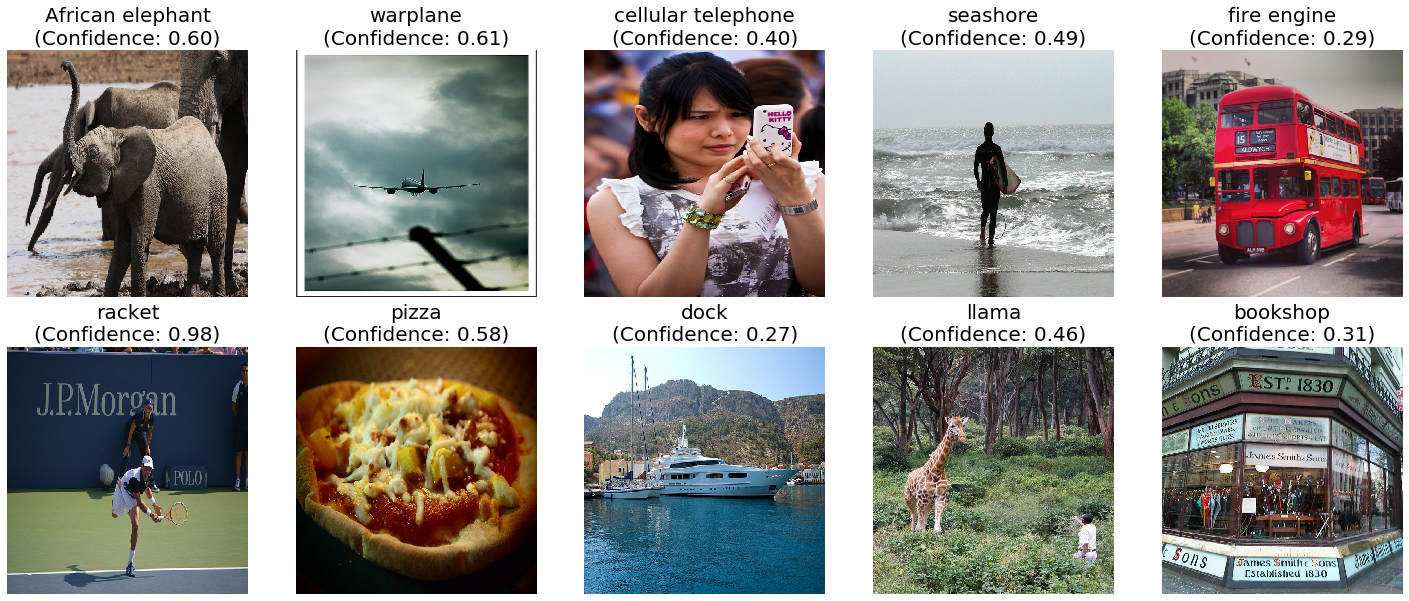

In [12]:
# I hand-picked some images to display predictions for. I use these images for predicted captions in the last 
#section of this notebook.
selected_images_to_view = ['COCO_val2014_000000000757.jpg','COCO_val2014_000000001029.jpg',
                           'COCO_val2014_000000001296.jpg','COCO_val2014_000000001369.jpg',
                           'COCO_val2014_000000001584.jpg','COCO_val2014_000000000885.jpg',
                           'COCO_val2014_000000003690.jpg','COCO_val2014_000000003832.jpg',
                           'COCO_val2014_000000004286.jpg','COCO_val2014_000000007444.jpg']

# Figure to plot
f, ax = pylab.subplots(2,5,figsize=(25,10))

# Processing each of the hand-picked images and display
for batch_index,fname in enumerate(selected_images_to_view):
    # Row and column in the plot the current image is going
    ri, ci = batch_index//5, batch_index%5
    # Create the full path 
    full_path_fname = os.path.join('image_caption_data',*('train_valid','images',fname))    
    
    # Load the image
    img_data = Image.open(full_path_fname)
    
    # Prediction data from earlier saved temp files
    img_prediction = test_softmax_predictions[fname][1]
    img_prob = test_softmax_predictions[fname][0]
    
    # Display each axes
    ax[ri][ci].imshow(img_data,aspect='auto')
    ax[ri][ci].set_title(class_names[img_prediction].split(',')[0]+'\n(Confidence: '+str('%.2f'%img_prob)+')',fontsize=20)
    ax[ri][ci].axis('off')

pylab.subplots_adjust(hspace=0.2)
pylab.savefig('vgg-predictions.png')
pylab.show()

## Preparing Data for the LSTM Training
If you run all the above code successfully, and got reasonable class predictions, you can directly start from here (after running the import at the very top). Be sure to rename the files as follows:
* `train_image_encodings-tmp.json` *to* `train_image_encodings.json`
* `valid_image_encodings-tmp.json` *to* `valid_image_encodings.json`

### Reading the Annotations

Next step is to read the annotations of the images which are found at `image_caption_data/train_valid/annotations`. This will result with the following entities.

* Dictionary mapping of the image IDs to filenames (`id_to_fname_map`)
* Dictionary mapping of the filenames to captions (`train_fname_to_caption_map` and `valid_fname_to_caption_map`).    
  * For example, `train_fname_to_caption_map` will be of the format `{fname1: [[cap1_w1, cap1_w2, ...], [cap2_w1, ...], [cap3_w1, ...]], fname2: [[cap1_w1, cap1_w2, ...], [cap2_w1, ...], [cap3_w1, ...]], ...}`

In [14]:
def preprocess_caption(capt):
    '''
    A simple text preprocessing function
    '''
    capt = capt.replace('-',' ')
    capt = capt.replace(',','')
    capt = capt.replace('.','')
    capt = capt.replace('"','')
    capt = capt.replace('!','')
    capt = capt.replace(':','')
    capt = capt.replace('/','')
    capt = capt.replace('?','')
    capt = capt.replace(';','')
    capt = capt.replace('\' ',' ')
    capt = capt.replace('\n',' ') 
    
    return capt.lower()

# Specifying the JSON file with the feature encoding of images
train_image_file = os.path.join('image_caption_data',*('train_valid', 'image_encodings', 'train_image_encodings.json'))
valid_image_file = os.path.join('image_caption_data',*('train_valid', 'image_encodings', 'valid_image_encodings.json'))
# Get train and validation filenames (we use testing and validation intechangably here)
train_image_fnames = (json.load(open(train_image_file)).keys())
valid_image_fnames = (json.load(open(valid_image_file)).keys())

# Get the actual image names (witout full path) for training and validation data
train_filename_tails = [os.path.split(path_str)[1] for path_str in train_image_filenames]
test_filename_tails = [os.path.split(path_str)[1] for path_str in test_image_filenames]

# Loading annotation data
annotations_fname = os.path.join('image_caption_data', *('train_valid', 'annotations', 'captions_val2014.json'))
data = json.load(open(annotations_fname))

# This variable holds all the unique words in captions
# Used to create vocabulary
unique_words = list()

# Dictionary: image-id -> filename
id_to_fname_map = {}
for item in data['images']:
    id_to_fname_map[item['id']] = item['file_name']

# Dictionary: filename -> caption list
train_fname_to_caption_map, valid_fname_to_caption_map = {},{}

# To store maximum caption length
max_caption_length = 0

# Store length of each caption we encounter which
# then is used to calculate the mean and standard deviation
all_cap_lengths = []

# Go through each annotation and store them
for item in data['annotations']:
    
    # Preprocess the annotation
    pre_caption = preprocess_caption(item['caption'])
    split_pre_caption = pre_caption.split(' ')
    # Get caption length (number of words)
    capt_len = len(split_pre_caption)
    all_cap_lengths.append(capt_len)
    
    # Update max caption length if needed
    if capt_len > max_caption_length:
        max_caption_length = capt_len

    # If the image the current annotation belongs to is 
    # in the train data ...
    if id_to_fname_map[item['image_id']]  in train_filename_tails and \
    id_to_fname_map[item['image_id']] in train_image_fnames:
        
        # Update the train_fnam_to_caption_map with new annotation
        if id_to_fname_map[item['image_id']] not in train_fname_to_caption_map:
            train_fname_to_caption_map[id_to_fname_map[item['image_id']]] = [pre_caption]
        else:
            train_fname_to_caption_map[id_to_fname_map[item['image_id']]].append(pre_caption)

    # If the image the current annotation belongs to is 
    # in the validation data ...
    elif id_to_fname_map[item['image_id']] in test_filename_tails and id_to_fname_map[item['image_id']] in valid_image_fnames:
        
        # Update the valid_fnam_to_caption_map with new annotation
        if id_to_fname_map[item['image_id']] not in valid_fname_to_caption_map:
            valid_fname_to_caption_map[id_to_fname_map[item['image_id']]] = [pre_caption]
        else:
            valid_fname_to_caption_map[id_to_fname_map[item['image_id']]].append(pre_caption)

    # Update the string that contains all the captions
    unique_words =  list(set(unique_words).union(set(split_pre_caption)))

# Print some statistics of the captions
print('Max caption length: ',max_caption_length)
print('Mean caption length: ',np.mean(all_cap_lengths))
print('Stddev captions: ', np.std(all_cap_lengths))
print('\nSample caption data')
print(list(train_fname_to_caption_map.items())[:10])


Max caption length:  56
Mean caption length:  10.622163885242827
Stddev captions:  2.420075651000928

Sample caption data
[('COCO_val2014_000000203564.jpg', ['a bicycle replica with a clock as the front wheel', 'the bike has a clock as a tire', 'a black metal bicycle with a clock inside the front wheel', 'a bicycle figurine in which the front wheel is replaced with a clock ', 'a clock with the appearance of the wheel of a bicycle ']), ('COCO_val2014_000000179765.jpg', ['a black honda motorcycle parked in front of a garage', 'a honda motorcycle parked in a grass driveway', 'a black honda motorcycle with a dark burgundy seat', 'ma motorcycle parked on the gravel in front of a garage', 'a motorcycle with its brake extended standing outside']), ('COCO_val2014_000000322141.jpg', ['a room with blue walls and a white sink and door', 'blue and white color scheme in a small bathroom', 'this is a blue and white bathroom with a wall sink and a lifesaver on the wall', 'a blue boat themed bathroom 

### Creating the Vocabulary
Here, using the unique words saved,I created the `dictionary`, `reverse_dictionary` and `vocabulary_size`.

In [15]:
# Add two special tokens to the dictionary
dictionary = {'SOS':0, 'EOS': 1}

# Create an ID for each word in the unique_words
for tg in unique_words:
    dictionary[tg] = len(dictionary)

# Create the reverse dictionary
reverse_dictionary = dict([(v,k) for k,v in dictionary.items()]) 

print('\nSample Dictionary Items')
print(list(dictionary.items())[:10])
print('\nSample Reverse Dictionary Items')
print(list(reverse_dictionary.items())[:10])
print('\nVocabulary size: ',len(dictionary))

# Just checking if the dictionary and reverse dictionary
# are correct
assert 'horse' == reverse_dictionary[dictionary['horse']]

vocabulary_size = len(dictionary)

del train_image_fnames, valid_image_fnames


Sample Dictionary Items
[('SOS', 0), ('EOS', 1), ('', 2), ('tousled', 3), ('because', 4), ('wear', 5), ('candlelight', 6), ("shoe's", 7), ('bale', 8), ('circus', 9)]

Sample Reverse Dictionary Items
[(0, 'SOS'), (1, 'EOS'), (2, ''), (3, 'tousled'), (4, 'because'), (5, 'wear'), (6, 'candlelight'), (7, "shoe's"), (8, 'bale'), (9, 'circus')]

Vocabulary size:  17954


### Making Captions Numerical

Converts the image captions words to numeric values by replacing the word string with its ID given by the `dictionary`.

In [16]:
train_fname_caption_numeric_tuples = []
valid_fname_caption_numeric_tuples = []

# Add SOS to beginning of sentence, Add EOS s.t. all captions size = max_caption_length (read padding)
# we need to make the max_cap_length even (12) s.t. when we add the image vector the full length is odd (13.
# Then we can generate an unroll a single batch in two steps
# We do the 6 unrollings per a single batch of images (defined later), 
# therefore needing 2 iterations to process a full batch
# If you have a large GPU, you can set this to 12 (image feature vec + caption), 
# which will increase computational efficiency
max_caption_length = 12

# Traverse through each and every training caption
for k,v in train_fname_to_caption_map.items():
    # Each image has several captions
    for cap in v:
        # Split the caption to words
        cap_tokens = cap.split(' ')
        # Insert a SOS at the beginning
        cap_tokens.insert(0,'SOS')
        # If the sentence is short, append EOS until the caption is max_caption_length long
        if len(cap_tokens)<max_caption_length:
            cap_tokens.extend(['EOS' for _ in range(max_caption_length-len(cap_tokens))])
        # If the sentence is long, truncate the sentence so the caption is max_caption_length long
        if len(cap_tokens) > max_caption_length:
            del cap_tokens[max_caption_length:]
        
        # Make sure the processed caption is max_caption_length long
        assert len(cap_tokens)==max_caption_length
        
        # Replace each word in the caption with word ID
        num_cap = []
        for word in cap_tokens:
            num_cap.append(dictionary[word])
        
        # Add the numerical caption to the list
        train_fname_caption_numeric_tuples.append([k,num_cap])

# Process all the captions in the validation set similarl
# to the training set
for k,v in valid_fname_to_caption_map.items():
    for cap in v:
        cap_tokens = cap.split(' ')
        cap_tokens.insert(0,'SOS')
        if len(cap_tokens)<max_caption_length:
            cap_tokens.extend(['EOS' for _ in range(max_caption_length-len(cap_tokens))])
        if len(cap_tokens) > max_caption_length:
            del cap_tokens[max_caption_length:]
        
        assert len(cap_tokens)==max_caption_length
        num_cap = []
        for word in cap_tokens:
            num_cap.append(dictionary[word])
        
        valid_fname_caption_numeric_tuples.append([k,num_cap])

print(train_fname_caption_numeric_tuples[:10])

# Persist the numerical captions so that we can run the code from the next cell onwards
# if needed
with open(os.path.join('tmp','tmp_train_fname_caption_numeric_tuples.pkl'),'wb') as f:
    pickle.dump(train_fname_caption_numeric_tuples,f)
with open(os.path.join('tmp','tmp_valid_fname_caption_numeric_tuples.pkl'),'wb') as f:
    pickle.dump(valid_fname_caption_numeric_tuples,f)
with open(os.path.join('tmp','tmp_reverse_dictionary.pkl'),'wb') as f:
    pickle.dump(reverse_dictionary,f)

[['COCO_val2014_000000203564.jpg', [0, 11754, 3479, 17550, 17535, 11754, 9990, 5676, 11738, 14623, 14905, 1]], ['COCO_val2014_000000203564.jpg', [0, 11738, 3693, 13631, 11754, 9990, 5676, 11754, 17133, 1, 1, 1]], ['COCO_val2014_000000203564.jpg', [0, 11754, 5534, 4415, 3479, 17535, 11754, 9990, 5553, 11738, 14623, 14905]], ['COCO_val2014_000000203564.jpg', [0, 11754, 3479, 11034, 11013, 2932, 11738, 14623, 14905, 1452, 14034, 17535]], ['COCO_val2014_000000203564.jpg', [0, 11754, 9990, 17535, 11738, 16684, 2720, 11738, 14905, 2720, 11754, 3479]], ['COCO_val2014_000000179765.jpg', [0, 11754, 5534, 816, 6616, 13554, 11013, 14623, 2720, 11754, 17271, 1]], ['COCO_val2014_000000179765.jpg', [0, 11754, 816, 6616, 13554, 11013, 11754, 7395, 1377, 1, 1, 1]], ['COCO_val2014_000000179765.jpg', [0, 11754, 5534, 816, 6616, 17535, 11754, 2233, 17043, 7117, 1, 1]], ['COCO_val2014_000000179765.jpg', [0, 3283, 6616, 13554, 12046, 11738, 13886, 11013, 14623, 2720, 11754, 17271]], ['COCO_val2014_00000017

## Learning the Word Embeddings with CBOW
You can find the logic for this part in the `word2vec.py` file. I used the CBOW model to learn the word embeddings for the words present in the captions.

In [17]:
tot_captions = len(train_fname_caption_numeric_tuples) + len(valid_fname_caption_numeric_tuples)

only_captions = np.asarray([c for _,c in train_fname_caption_numeric_tuples],dtype=np.int32)
only_captions = np.append(only_captions, np.asarray([c for _,c in valid_fname_caption_numeric_tuples],dtype=np.int32),axis=0)
print(only_captions.shape)
print(only_captions[0,:])
print([dictionary[reverse_dictionary[w]] for w in only_captions[0,:]])

# Data points in a single batch
batch_size = 64
embedding_size = 1000 # Dimension of the embedding vector.

# How many words to consider left and right.
# Skip gram by design does not require to have all the context words in a given step
# However, for CBOW that's a requirement, so we limit the window size
window_size = 3

word2vec.define_data_and_hyperparameters(
    tot_captions, only_captions, reverse_dictionary, 
    embedding_size, vocabulary_size, max_caption_length
)

# We make sure data is generated properly
word2vec.print_some_batches()

# Define TensorFlow ops
word2vec.define_word2vec_tensorflow(batch_size)

# Run the training process
word2vec.run_word2vec(batch_size)


W0903 13:55:22.588592 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:122: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0903 13:55:22.590587 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:125: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 13:55:22.605561 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:136: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 13:55:22.626491 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:139: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.



(202634, 12)
[    0 11754  3479 17550 17535 11754  9990  5676 11738 14623 14905     1]
[0, 11754, 3479, 17550, 17535, 11754, 9990, 5676, 11738, 14623, 14905, 1]

with window_size = 1:
    batch: [['SOS', 'train'], ['SOS', 'close'], ['SOS', 'sheep'], ['SOS', 'garden'], ['SOS', 'train'], ['SOS', 'are'], ['SOS', 'pizza'], ['SOS', 'man']]
    labels: ['a', 'a', 'a', 'a', 'a', 'there', 'sliced', 'a']

with window_size = 2:
    batch: [['SOS', 'a', 'and', 'white'], ['SOS', 'a', 'and', 'several'], ['SOS', 'wide', 'kitchen', 'area'], ['SOS', 'a', 'player', 'swings'], ['SOS', 'a', 'holding', 'a'], ['SOS', 'a', 'on', 'a'], ['SOS', 'two', 'sleeping', 'with'], ['SOS', 'earthen', 'clay', 'pot']]
    labels: ['blue', 'motorcycle', 'open', 'baseball', 'man', 'person', 'cats', 'toned']
Defining 6 embedding lookups representing each word in the context
Stacked embedding size: [64, 1000, 6]
Reduced mean embedding size: [64, 1000]


W0903 13:55:22.813000 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:169: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0903 13:55:23.185091 31084 deprecation_wrapper.py:119] From C:\Users\Parth\Documents\Projects\nlp\ch9\word2vec.py:193: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 2000: 0.474797
Average loss at step 4000: 0.325529
Average loss at step 6000: 0.278753
Average loss at step 8000: 0.244977
Average loss at step 10000: 0.223159
Nearest to bale: ascot, ingredient, toga,
Nearest to snowflakes: wedded, monkeys, obsolete,
Nearest to circus: roping, achild, packs,
Nearest to cladly: carolina, spindly, refrigerate,
Nearest to elizbeth: delight, toiilet, dealer,
Nearest to drawers: teammate, morning, kiss,
Nearest to : dunkin, slum, subbed,
Nearest to cowgirl: commuters, populated, yoing,
Nearest to fee: avoid, circling, rec,
Nearest to polo: bt, cutters, spooky,
Nearest to mascara: penguin, frisbie, genuinely,
Nearest to centurion: vedgies, bethroom, maps,
Nearest to glossy: outfielders, skiesat, grop,
Nearest to claim: carved, cell, patrolling,
Nearest to plant: blackened, nestled, sidelight,
Nearest to frisebeedisc: breaded, deco, faccia,
Average loss at step 12000: 0.195419
Average loss at step 14000: 0.187656
Average loss

Average loss at step 92000: 0.030582
Average loss at step 94000: 0.031241
Average loss at step 96000: 0.032044
Average loss at step 98000: 0.029513
Average loss at step 100000: 0.028028
Nearest to bale: ascot, collar, ingredient,
Nearest to snowflakes: monkeys, wedded, streaks,
Nearest to circus: packs, indifferent, roping,
Nearest to cladly: carolina, spindly, committing,
Nearest to elizbeth: delight, waterboarding, grazed,
Nearest to drawers: teammate, kiss, built,
Nearest to : subbed, dunkin, slum,
Nearest to cowgirl: yoing, replacing, effect,
Nearest to fee: series, circling, dome,
Nearest to polo: baseball, mp3, paddock,
Nearest to mascara: frisbie, penguin, satellites,
Nearest to centurion: vedgies, bethroom, maps,
Nearest to glossy: cooktop, paneled, skiesat,
Nearest to claim: carved, penned, patrolling,
Nearest to plant: outhouse, cappuccino, appreciating,
Nearest to frisebeedisc: breaded, puddle, socializing,


## RESTORATION POINT: Load Numerical Captions from Disk
Only run this code if you closed the notebook after running the code above and starting fresh. *You do not need to run this if you have run the above code successfully*.

In [5]:
# Set the image file directory
image_file_dir = os.path.join('image_caption_data', *('train_valid','images'))
# Get the filenames in the directory
image_filenames = [os.path.join(image_file_dir,f) \
                   for f in os.listdir(image_file_dir) \
                   if os.path.isfile(os.path.join(image_file_dir, f)) and f.endswith('.jpg')]

# Splitting training and testing data
train_image_filenames = image_filenames[1000:] 
test_image_filenames = image_filenames[:1000]

if os.path.exists(os.path.join('tmp','tmp_train_fname_caption_numeric_tuples.pkl')):
    with open(os.path.join('tmp','tmp_train_fname_caption_numeric_tuples.pkl'),'rb') as f:
        train_fname_caption_numeric_tuples = pickle.load(f)
else:
    print('You cannot use this restoration point as '+
          'the file tmp/tmp_train_fname_caption_numeric_tuples.pkl does not exist')
    
if os.path.exists(os.path.join('tmp','tmp_valid_fname_caption_numeric_tuples.pkl')):
    with open(os.path.join('tmp','tmp_valid_fname_caption_numeric_tuples.pkl'),'rb') as f:
        valid_fname_caption_numeric_tuples = pickle.load(f)
else:
    print('You cannot use this restoration point as '+
          'the file tmp/tmp_valid_fname_caption_numeric_tuples.pkl does not exist')
        
if os.path.exists(os.path.join('tmp','tmp_reverse_dictionary.pkl')):
    with open(os.path.join('tmp','tmp_reverse_dictionary.pkl'),'rb') as f:
        reverse_dictionary = pickle.load(f)
else:
    print('You cannot use this restoration point as '+
          'the file tmp/tmp_reverse_dictionary.pkl does not exist')

## Creating a Validation Caption Dictionary

Here I created a dictionary `valid_fname_caption_map` which has the format `{fname_1:[[caption 1 word list],[caption 2 word list],...,[caption 3 word list]]}`

In [18]:
valid_fname_caption_map = {}
for fn in test_image_filenames:
    valid_fname_caption_map[os.path.split(fn)[1]] = [] 
    
for fn,c in valid_fname_caption_numeric_tuples:
    caption_w_list = []
    for w_id in c:
        if not (reverse_dictionary[w_id]=='SOS' or reverse_dictionary[w_id]=='EOS'):
            caption_w_list.append(reverse_dictionary[w_id])
    valid_fname_caption_map[fn].append(caption_w_list)

print_idx = 0
for k,v in valid_fname_caption_map.items():
    if print_idx>5:
        break
    print(k,':',v)
    print_idx += 1

COCO_val2014_000000000042.jpg : [['this', 'wire', 'metal', 'rack', 'holds', 'several', 'pairs', 'of', 'shoes', 'and', 'sandals'], ['a', 'dog', 'sleeping', 'on', 'a', 'show', 'rack', 'in', 'the', 'shoes'], ['various', 'slides', 'and', 'other', 'footwear', 'rest', 'in', 'a', 'metal', 'basket', 'outdoors'], ['a', 'small', 'dog', 'is', 'curled', 'up', 'on', 'top', 'of', 'the', 'shoes'], ['a', 'shoe', 'rack', 'with', 'some', 'shoes', 'and', 'a', 'dog', 'sleeping', 'on']]
COCO_val2014_000000000073.jpg : [['a', 'motorcycle', 'parked', 'in', 'a', 'parking', 'space', 'next', 'to', 'another', 'motorcycle'], ['an', 'old', 'motorcycle', 'parked', 'beside', 'other', 'motorcycles', 'with', 'a', 'brown', 'leather'], ['motorcycle', 'parked', 'in', 'the', 'parking', 'lot', 'of', 'asphalt'], ['a', 'close', 'up', 'view', 'of', 'a', 'motorized', 'bicycle', 'sitting', 'in', 'a'], ['the', 'back', 'tire', 'of', 'an', 'old', 'style', 'motorcycle', 'is', 'resting', 'in']]
COCO_val2014_000000000074.jpg : [['a',

## Generating Batches of Data
The following object generates a batch of data which will be used to train the LSTM. More specifically the generator breaks the batch generation to two tasks. It will either output image feature vector followed by a sequence of words, or it can output just a sequence of words. First it decomposes a given sequence of words into `batch_size` segments. It also maintains a cursor for each segment. So whenever it creates a batch of data, we sample one item from each segment and update the cursor of each segment. 

In [20]:
# This is the embedding/image feature vector size
input_size = 1000 

# Get the total number of captions
tot_captions = len(train_fname_caption_numeric_tuples) + len(valid_fname_caption_numeric_tuples)

class DataGeneratorSeq(object):
    
    def __init__(self,batch_size,num_unroll,cap_length,image_vector_file, caption_embedding_file, is_train):
        
        # The size of a single batch of data
        self._batch_size = batch_size
        # Number of unrolling steps to perform
        # To make sure we process all the words in the sequence
        # We make this a factorial of the max_caption_length
        self._num_unroll = num_unroll
        # Caption length (= max_caption_length)
        self._cap_length = cap_length
        # Cursors for each segment
        self._cursor = [0 for offset in range(self._batch_size)]
        
        # Load the image feature vectors
        self._image_data = json.load(open(image_vector_file))
        # Load the word embeddings
        self._word_embeddings = np.load(caption_embedding_file)
        # Check if we are processing training data or validation data
        self._is_train = is_train
        self._cap_ids = None
        
        # Change the _fname_caption_tuples and _tot_captions
        # variables according to whether we process train or test data
        self._fname_caption_tuples = train_fname_caption_numeric_tuples if self._is_train else train_fname_caption_numeric_tuples
        self._tot_captions = len(train_fname_caption_numeric_tuples) if self._is_train else len(valid_fname_caption_numeric_tuples)
        
        
    def next_batch(self,cap_ids,first_sample):
        '''
        Produces a batch of data (inputs and labels)
        cap_ids: The ids of the captions that we output as data
        first_sample: denotes if we are processing a fresh set of captions
        or continuing from a previously processed batch
        '''
        
        # Store the batch inputs (image feature vector followed by words)
        # Word embeddings
        batch_data = np.zeros((self._batch_size,input_size),dtype=np.float32)
        # Store the batch labels (same as batch inputs but shifted by 1)
        # One hot encoded vectors
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        
        # Fill each of the batch indices
        for b in range(self._batch_size):
            
            cap_id = cap_ids[b] # Current caption id
            # Current image feature vector
            cap_image_vec = self._image_data[self._fname_caption_tuples[cap_id][0]]
            # Current caption
            cap_text = self._fname_caption_tuples[cap_id][1]
            
            # If the cursor exceeds the length of the caption, reset
            if self._cursor[b]+1>=self._cap_length:
                self._cursor[b] = 0
            
            # If processing a fresh set of cap IDs
            # The first sample should be the image feature vector
            if first_sample:
                batch_data[b] = cap_image_vec
                batch_labels[b] = np.zeros((vocabulary_size),dtype=np.float32)
                batch_labels[b,cap_text[0]] = 1.0
            # If continuing from an already processed batch
            # Keep producing the current word as the input and the next word as the output
            else:
                batch_data[b] = self._word_embeddings[cap_text[self._cursor[b]],:]
                batch_labels[b] = np.zeros((vocabulary_size),dtype=np.float32)
                batch_labels[b,cap_text[self._cursor[b]+1]] = 1.0
                
                # Increment the cursor
                self._cursor[b] = (self._cursor[b]+1)%self._cap_length
            
        return batch_data,batch_labels
        
    def unroll_batches(self,first_set):
        '''
        Unroll a set of batches
        '''
        # If we want a fresh new set of captions
        # Get a set of batch_size captions randomly sampled
        if first_set:
            self._cap_ids = np.random.randint(0,self._tot_captions,self._batch_size)
            self._cursor = [0 for _ in range(self._batch_size)]
        
        # Keep unrolling batches until we have _num_unroll batches
        unroll_data,unroll_labels = [],[]
        for ui in range(self._num_unroll):
            # The first batch in any batch of captions is different
            if first_set and ui==0:
                data, labels = self.next_batch(self._cap_ids,True)            
            else:
                data, labels = self.next_batch(self._cap_ids,False)            
            unroll_data.append(data)
            unroll_labels.append(labels)
        
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        '''
        Reset the cursors
        '''
        self._cursor = [0 for offset in range(self._batch_size)]
        
# Running a tiny set to see if the implementation correct
dg = DataGeneratorSeq(
    batch_size=5,num_unroll=5,cap_length=12,
    image_vector_file=os.path.join('image_caption_data',*('train_valid', 'image_encodings', 'train_image_encodings.json')), 
                      caption_embedding_file=os.path.join('image_caption_data','caption-embeddings.npy'), 
                      is_train = True)

u_data, u_labels = dg.unroll_batches(True)

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs:')
    for single_dat in dat_ind:
        print('\t%s'%(single_dat[:5]),end=", ")
    print('\n\tOutput:')
    for single_lbl in lbl_ind:        
        print('\t%s'%(np.argmax(single_lbl)),end=", ")



Unrolled index 0
	Inputs:
	[ 4.0326204  4.7672496 -1.522292  -2.5535097 -0.690054 ], 	[-5.4224324 -3.6089902 -0.4324799 -1.241421   1.3789715], 	[-2.784224  -2.2302685  1.7948407  0.5517225  2.111936 ], 	[-2.934761  -1.3206633 -1.291907  -3.0745296 -0.6257835], 	[-2.6528988  -0.83797586 -2.084084   -2.821405   -3.1717868 ], 
	Output:
	0, 	0, 	0, 	0, 	0, 

Unrolled index 1
	Inputs:
	[ 0.02946964  0.03920585  0.00647759  0.03101287 -0.01604523], 	[ 0.02946964  0.03920585  0.00647759  0.03101287 -0.01604523], 	[ 0.02946964  0.03920585  0.00647759  0.03101287 -0.01604523], 	[ 0.02946964  0.03920585  0.00647759  0.03101287 -0.01604523], 	[ 0.02946964  0.03920585  0.00647759  0.03101287 -0.01604523], 
	Output:
	11754, 	11754, 	11754, 	11754, 	11754, 

Unrolled index 2
	Inputs:
	[ 0.01967494 -0.01211585 -0.02776749  0.00661899 -0.01547655], 	[ 0.01967494 -0.01211585 -0.02776749  0.00661899 -0.01547655], 	[ 0.01967494 -0.01211585 -0.02776749  0.00661899 -0.01547655], 	[ 0.01967494 -0.0121158

## Defining LSTM  for learning Image Captions
Now that the image feature extraction is done, I can define LSTM specific code for caption generation. This part defines the following:
* A data generator (`DataGeneratorSeq`) that generates a single unrolling of batches of data. A batch of data consists of the sequence of cations preceded by the image feature vector. A single batch is of shape `[batch_size, 1000]`.
* Next I define the LSTM cell related computations.

### Defining hyperparameters

Here we define several hyperparameters such as `batch_size`, `input_size`, ...

In [21]:
input_size = 1000
embedding_size = 1000
sequence_length = 12

num_nodes = 192
batch_size = 25
num_unrollings = 6

### Defining Inputs and Outputs

In the code there are two different types of inputs: 
* Training inputs (batch_size > 1 with unrolling) 
* Validation/Test inputs (An unseen validation dataset) (bach_size > 1, no unrolling)


In [22]:
tf.reset_default_graph()

# Input data.
train_inputs, train_labels = [],[]
train_inputs_embeds, train_labels_ohe = [],[]

for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,input_size],name='train_inputs_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size], name = 'train_labels_%d'%ui))

# Testing: Given an image generate the text.
test_input = tf.placeholder(tf.float32, shape=[batch_size,input_size], name='test_inputs')

### Defining Model Parameters

Now the model parameters. Compared to RNNs, LSTMs have a large number of parameters. Each gate (input, forget, memory and output) has three different sets of parameters...

In [23]:
# Input gate (i_t) - How much memory to write to cell state
# Connects the current input to the input gate
ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], stddev=0.01))
# Connects the previous hidden state to the input gate
im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev=0.01))
# Bias of the input gate
ib = tf.Variable(tf.random_uniform([1, num_nodes],0.0, 0.01))

# Forget gate (f_t) - How much memory to discard from cell state
# Connects the current input to the forget gate
fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], stddev=0.01))
# Connects the previous hidden state to the forget gate
fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev=0.01))
# Bias of the forget gate
fb = tf.Variable(tf.random_uniform([1, num_nodes],0.0, 0.01))

# Candidate value (c~_t) - Used to compute the current cell state
# Connects the current input to the candidate
cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], stddev=0.01))
# Connects the previous hidden state to the candidate
cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev=0.01))
# Bias of the candidate
cb = tf.Variable(tf.random_uniform([1, num_nodes],0.0,0.01))

# Output gate - How much memory to output from the cell state
# Connects the current input to the output gate
ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], stddev=0.01))
# Connects the previous hidden state to the output gate
om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev=0.01))
# Bias of the output gate
ob = tf.Variable(tf.random_uniform([1, num_nodes],0.0,0.01))

# Softmax Classifier weights and biases.
w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], stddev=0.01))
b = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

# Variables saving state across unrollings.
# Hidden state
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False, name='test_cell')
# Cell state
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False, name='train_cell')

# Hidden and cell state variables for test data
saved_test_output = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False, name='test_hidden')
saved_test_state = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False, name='test_cell')

### Defining LSTM computations
Here I defined the LSTM cell computations as a concise function, which I then used to define training and test-time inference logic.

In [24]:
# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. 
    """
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state


In [25]:
# =========================================================
#Training related inference logic

# Keeps the calculated state outputs in all the unrollings
# Used to calculate loss
outputs = list()

# These two python variables are iteratively updated
# at each step of unrolling
output = saved_output
state = saved_state

# Compute the hidden state (output) and cell state (state)
# recursively for all the steps in unrolling
for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    # Append each computed output value
    outputs.append(output)

# Calculate the score values
logits = tf.matmul(tf.concat(axis=0, values=outputs), w) + b

# Predictions.
train_prediction = tf.nn.softmax(logits)

# ========================================================================
# Testing phase related inference logic

# Compute the LSTM cell output for testing data
test_output, test_state = lstm_cell(
    test_input, saved_test_output, saved_test_state
)

# Make sure that the state variables are updated
# before moving on to the next iteration of generation
with tf.control_dependencies([saved_test_output.assign(test_output),
                            saved_test_state.assign(test_state)]):
    test_prediction = tf.nn.softmax(tf.nn.xw_plus_b(test_output, w, b))

### Calculating LSTM Loss
It's a typical cross entropy loss calculated over all the scores obtained for training data (`loss`).

In [26]:
# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                            saved_state.assign(state)]):
    # When defining the loss it needs to be summed accross all time steps but averaged across the batch axis
    loss = 0
    split_logits = tf.split(logits,num_or_size_splits=num_unrollings)
    
    for lgt,lbl in zip(split_logits, train_labels):
        loss += tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(logits=lgt, labels=lbl)
        )


## Defining Learning Rate and the Optimizer with Gradient Clipping
I used the Adam optimizer as it is one of the best optimizers out there. I also used gradient clipping to prevent any gradient explosions!

In [27]:
# This variable and operation are used to decay the learning rate

global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)

# Defining a decaying learning rate
learning_rate = tf.train.exponential_decay(
    0.001, global_step, decay_steps=1, decay_rate=0.75, staircase=True)
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

# Gradient clipping
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

W0903 14:22:17.129036 31084 deprecation.py:323] From C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Resetting Operations for Resetting Hidden States
Sometimes the state variable needs to be reset (e.g. when starting predictions at a beginning of a new epoch)

In [28]:
# Reset train state
reset_train_state = tf.group(tf.assign(saved_state, tf.zeros([batch_size, num_nodes])),
                          tf.assign(saved_output, tf.zeros([batch_size, num_nodes])))

# Reset validation/test state
reset_test_state = tf.group(
saved_test_output.assign(tf.zeros([batch_size, num_nodes])),
saved_test_state.assign(tf.zeros([batch_size, num_nodes])))

### Running Image Caption Generation

Now we can run the image caption generation using the TensorFlow functions defined above. First, create data generators to generate training and test data. 
Then train the algorithm for `num_steps` number of steps. Each step consists of two iterations. First iteration processes the first half of the full sequence of the inputs in a batch where the second iteration processes the second half. I also calculate the BLEU score over all the data in the validation set as well as display captions generated for a set of hand-picked examples.

But what is the BLEU Score? Here's a helpful link:https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

tl;dr BLEU  is a metric for evaluating a generated sentence to a reference sentence.
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

In [29]:
# Training data generator
train_data_generator = DataGeneratorSeq(
    batch_size=batch_size,num_unroll=num_unrollings,cap_length=sequence_length,
    image_vector_file=os.path.join('image_caption_data',*('train_valid', 'image_encodings' ,'train_image_encodings.json')), 
    caption_embedding_file=os.path.join('image_caption_data','caption-embeddings.npy'),
    is_train=True)

# Validation data generator
valid_data_generator = DataGeneratorSeq(
    batch_size=batch_size,num_unroll=1,cap_length=sequence_length,
    image_vector_file=os.path.join('image_caption_data', *('train_valid', 'image_encodings', 'valid_image_encodings.json')), 
    caption_embedding_file=os.path.join('image_caption_data', 'caption-embeddings.npy'),is_train=False)

# These image will be used to visually analyze the generated text
selected_images_to_view = ['COCO_val2014_000000000757.jpg','COCO_val2014_000000001029.jpg',
                           'COCO_val2014_000000001296.jpg','COCO_val2014_000000001369.jpg','COCO_val2014_000000001584.jpg',
                          'COCO_val2014_000000000885.jpg','COCO_val2014_000000003690.jpg','COCO_val2014_000000003832.jpg',
                           'COCO_val2014_000000004286.jpg','COCO_val2014_000000007444.jpg']

# Loading the word embeddings
word_embeddings = np.load(os.path.join('image_caption_data', 'caption-embeddings.npy'))

# Loading validation image vectors
valid_image_data = json.load(
            open(os.path.join('image_caption_data',
                              *('train_valid' ,'image_encodings', 'valid_image_encodings.json')))
        )
valid_fnames, valid_image_vectors = valid_image_data.keys(), valid_image_data.values()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.allow_soft_placement=True
sess = tf.InteractiveSession(config=config)

# Initialize all variables
tf.global_variables_initializer().run()

bleu_over_time = [0]
# Used to decay the learning rate
bleu_drop = 0
bleu_drop_threshold = 10
max_bleu = 0

num_steps = 20001
print('Started Training')
for step in range(num_steps):
    
    # Each step has two training iterations
    # First iteration: Process the first half of the data sequence (image feature vector and following captions)
    # Second iteration: Processing the rest of the words in the caption
    
    # =================================================================
    # First step done starting from the image vector
    u_data, u_labels = train_data_generator.unroll_batches(first_set=True)
    
    # Populate the feed_dict dictionary
    feed_dict = {}
    for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
        feed_dict[train_inputs[ui]] = dat
        feed_dict[train_labels[ui]] = lbl

    # Running TensorFlow operations 
    _, l = sess.run([optimizer, loss], feed_dict=feed_dict)

    # =================================================================
    # Second iteration: Processing the rest of the words in the caption
    
    u_data, u_labels = train_data_generator.unroll_batches(first_set=False)
    
    feed_dict = {}
    for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
        feed_dict[train_inputs[ui]] = dat
        feed_dict[train_labels[ui]] = lbl    

    # Running TensorFlow operations
    _, l = sess.run([optimizer, loss], feed_dict=feed_dict)

    # Resetting hidden state for each batch
    sess.run(reset_train_state) 
    
    if (step+1)%100==0:
        # =======================================================================================
        # Validation/Testing phase
        
        print('\n============================ Step ',step+1,' ==================================')
        
        
        # Make sure the filenames and image vectors lists
        valid_fnames = list(valid_fnames)
        valid_image_vectors = list(valid_image_vectors)

        # This will be populated with all the predictions made,
        # for each of the 1000 images in the validation set
        all_test_predictions = ['' for _ in range(len(valid_fnames))]
        
        # Calculates the BLEU score for the validation set
        bleu_for_dataset = []
        
        # Process validation/test data as batches
        for test_batch_index in range(0, len(valid_fnames)-batch_size,batch_size):
            
            # The first input would be the batch of image vectors
            curr_inputs_batch = valid_image_vectors[test_batch_index: test_batch_index + batch_size]
            
            # Get the predictions out
            pred_batch = sess.run(test_prediction,feed_dict={test_input:np.asarray(curr_inputs_batch)})
            
            # Using the word ID, get the word string using the reverse dictionary for each item in the batch

            # This variable is used for display purposes alone
            pred_sentence_batch = [reverse_dictionary[np.asscalar(np.argmax(pred_batch[ri,:]))] for ri in range(batch_size)]
            
            # Get the word list predicted for each item in the batch
            # for max_caption_length+2 steps
            # Don't put the first word in to pred_word_list_batch as it is 'SOS' and 
            # it's not needed to calculate the BLEU
            # Then iteratively feed the previous prediction's word embedding
            # as the input of the next time step
            pred_word_list_batch = [[] for ri in range(batch_size)] 
            
            for valid_step in range(max_caption_length+2):
                # Get the corresponding word embedding
                curr_inputs_batch = word_embeddings[np.argmax(pred_batch,axis=1),:]
                
                # Get the prediction
                pred_batch = sess.run(test_prediction,feed_dict={test_input:curr_inputs_batch})
                
                # Update the prediction word list to calculate BLEU
                for bi1 in range(batch_size):
                    max_pred = np.asscalar(np.argmax(pred_batch[bi1]))
                    pred_sentence_batch[bi1] = pred_sentence_batch[bi1] + ' ' + reverse_dictionary[max_pred] 
                    
                    # If the output is EOS , do not add that to calculate BLEU
                    if reverse_dictionary[max_pred]  != 'EOS':
                        pred_word_list_batch[bi1] = pred_word_list_batch[bi1] + [reverse_dictionary[max_pred]]
            
            # Calculating BLEU for batch
            # A list of BLEU values for each prediction
            bleu_for_batch = []
            for bi in range(batch_size):
                all_test_predictions[test_batch_index+bi] = pred_sentence_batch[bi]
                bleu_for_batch.append(bleu_score.sentence_bleu(
                    valid_fname_caption_map[valid_fnames[test_batch_index+bi]], pred_word_list_batch[bi],
                    smoothing_function=bleu_score.SmoothingFunction().method4)
                                     )
                if valid_fnames[test_batch_index + bi] in selected_images_to_view:
                    print(valid_fnames[test_batch_index + bi],': ',pred_sentence_batch[bi])
            
            # Get the mean of the BLEUs for this batch and
            # append it to the global list
            bleu_for_dataset.append(np.mean(bleu_for_batch))
            
            # Reset test states
            sess.run(reset_test_state)
            
        print('BLEU-4 Score')
        current_bscore = np.mean(bleu_for_dataset)
        print('\t',current_bscore)
        
        # Decaying learning rate
        # If the bleu score has not improved in
        # bleu_drop_threshold steps
        if current_bscore < max_bleu:
            bleu_drop += 1
        else:
            bleu_drop = 0
            max_bleu = current_bscore
        
        if bleu_drop >= bleu_drop_threshold:
            sess.run(inc_gstep)
            print('Dropping learning rate')
            bleu_drop = 0
            max_bleu = 0
            
        bleu_over_time.append(current_bscore)

# Write the results to the disk
with open('image_captioning_no_pretrained_wordvec.csv', 'wt') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(bleu_over_time)

C:\Users\Parth\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Started Training

============================ Step  100  ==================================
COCO_val2014_000000000757.jpg :  SOS a a EOS a EOS EOS a EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a a a EOS a EOS EOS EOS EOS EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.07411345162842777

=================

COCO_val2014_000000001029.jpg :  SOS a man is on a street EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is sitting on a table EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is on a beach EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a train with a train with a street with a street EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a plate of a plate with a table with a table with a table
COCO_val2014_000000003832.jpg :  SOS a man is on a street EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing on a field EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a train with a train with a street EOS EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.20898746494659193

============================ Step  1000  ==================================
COCO_val2014_000000000757.jpg :  SOS a giraffe standing in a field EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a 

BLEU-4 Score
	 0.2506177083992167

============================ Step  1700  ==================================
COCO_val2014_000000000757.jpg :  SOS a group of elephants standing in the grass EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing a tennis court EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a man is flying a kite on a beach EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a woman on a table EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is riding a kite on a surfboard EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a train is parked on a street EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a plate of a plate of food on a plate EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a man is on a beach on a street EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a brown bear is standing on a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS 

COCO_val2014_000000003690.jpg :  SOS a plate of food on a table EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat with a large boat on a beach EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a street sign with a clock on a street EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.2663462585583217

============================ Step  2500  ==================================
COCO_val2014_000000000757.jpg :  SOS a group of elephants standing in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing a tennis racket EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a large airplane flying on the air EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a tie and a tie EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is riding a skateboard on a skateboard EOS EOS EOS EOS EOS
COCO_val2014_0000

COCO_val2014_000000003690.jpg :  SOS a plate of food with a plate of food EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a large boat with a large blue and white and white and a large
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a group of people are parked on a street EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.2771584988569096

============================ Step  3300  ==================================
COCO_val2014_000000000757.jpg :  SOS a group of elephants standing in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing a tennis racquet in a tennis court EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a person is flying a kite on a beach EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man holding a tie in a room EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a skateboard on a beach EOS EOS EOS EOS EOS EOS
COCO_val2014

COCO_val2014_000000001029.jpg :  SOS a plane is flying through the sky EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a tie and a tie EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is riding a wave on a surfboard EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus is parked in a city street EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a plate of food with a fork and a fork EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a large boat is sitting on a beach EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a herd of sheep standing in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a street sign with a clock on a city street EOS EOS EOS EOS
BLEU-4 Score
	 0.2765202834274428

============================ Step  4100  ==================================
COCO_val2014_000000000757.jpg :  SOS a man standing in a field with a fence EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  

COCO_val2014_000000007444.jpg :  SOS a street sign with a large clock on a street EOS EOS EOS EOS
BLEU-4 Score
	 0.27604445577803666

============================ Step  4800  ==================================
COCO_val2014_000000000757.jpg :  SOS a man standing on a field with a tree EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing tennis in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the sky EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man holding a tie and a man EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man on a surfboard on a surfboard EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus driving down a street EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a pizza with a pizza on a table EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a group of people are on a beach EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.j

COCO_val2014_000000003690.jpg :  SOS a plate of food with a sandwich on a table EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is parked on the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a frisbee in the grass EOS EOS
COCO_val2014_000000007444.jpg :  SOS a large bus is parked in the middle of a building EOS EOS EOS
BLEU-4 Score
	 0.280616469070274

============================ Step  5600  ==================================
COCO_val2014_000000000757.jpg :  SOS a couple of elephants standing in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing tennis racket EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a person is flying a kite on a surfboard EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a hot dog in a kitchen EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a wave on a surfboard EOS EOS EOS EOS EOS EOS
COCO_va

COCO_val2014_000000001296.jpg :  SOS a man is holding a cell phone EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is riding a surfboard on a surfboard EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus is parked in the street EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a pizza with a pizza on top of a plate EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat in a boat with a large boat in the water EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe is standing in the grass with a tree EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a large building with a clock on the side of a building EOS EOS
BLEU-4 Score
	 0.2796125595931394

============================ Step  6400  ==================================
COCO_val2014_000000000757.jpg :  SOS a elephant is walking in a field EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing with a tennis racket EOS EOS EOS EOS EOS EOS
COCO_val2014_000

BLEU-4 Score
	 0.2815029395196752

============================ Step  7100  ==================================
COCO_val2014_000000000757.jpg :  SOS a elephant is standing in the grass EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man in a white shirt and a tennis racket EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a runway EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a cell phone in a room EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man in a wetsuit with a surfboard on a beach EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus is parked on a street EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a plate of food with a pizza on it EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is parked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a group of sheep standing in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444

COCO_val2014_000000003690.jpg :  SOS a plate with a sandwich and a plate of food EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is parked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree in the grass EOS EOS
COCO_val2014_000000007444.jpg :  SOS a street sign with a traffic light and a street sign EOS EOS EOS
BLEU-4 Score
	 0.28754726879181053

============================ Step  7900  ==================================
COCO_val2014_000000000757.jpg :  SOS a elephant is standing in the grass EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing tennis with a tennis racket EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a runway EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man holding a cell phone in a room EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a surfboard on a beach EOS EOS EOS EOS EOS EOS


COCO_val2014_000000001296.jpg :  SOS a man holding a cell phone in a room EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is holding a frisbee on a skateboard EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus driving down a street with a bus on a street EOS EOS
COCO_val2014_000000003690.jpg :  SOS a plate of food with a sandwich and a plate of food EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is docked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree in a field EOS EOS
COCO_val2014_000000007444.jpg :  SOS a street sign with a clock on it EOS EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.2874736474127557

============================ Step  8700  ==================================
COCO_val2014_000000000757.jpg :  SOS a man riding a horse in a field EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man in a white shirt is holding a tennis racket EOS EOS EOS
COCO_val2014_0000000010

BLEU-4 Score
	 0.2891761761451363

============================ Step  9400  ==================================
COCO_val2014_000000000757.jpg :  SOS a elephant standing in a field with a tree EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a tennis player is swinging a tennis ball EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a runway EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a cell phone in a room EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a wave on a surfboard EOS EOS EOS EOS EOS EOS
COCO_val2014_000000001584.jpg :  SOS a bus driving down a street with a lot of cars EOS EOS EOS
COCO_val2014_000000003690.jpg :  SOS a pizza with a pizza on a table EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is docked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree in a field EOS EOS
COCO_val2014_00

COCO_val2014_000000003690.jpg :  SOS a pizza with a pizza on a table EOS EOS EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is docked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree in the grass EOS EOS
COCO_val2014_000000007444.jpg :  SOS a city street with a traffic light on a city street EOS EOS EOS
BLEU-4 Score
	 0.289983872211974

============================ Step  10200  ==================================
COCO_val2014_000000000757.jpg :  SOS a man riding a horse in the middle of a field EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing tennis with a tennis racket EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a cloudy day EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man holding a cell phone in a room EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man is surfing on a surfboard in the ocean EOS EOS EOS EOS
COCO_val201

COCO_val2014_000000003690.jpg :  SOS a plate of food with a plate of food and a plate EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is docked in the water EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field with a tree in the background EOS EOS
COCO_val2014_000000007444.jpg :  SOS a street sign with a clock on it EOS EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.2909852861852935

============================ Step  11000  ==================================
COCO_val2014_000000000757.jpg :  SOS a man standing in a field with a tree EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man in a white shirt and a tennis racket EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the sky on a cloudy day EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man holding a cell phone in a room EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a wave on a surfboard EOS EOS EOS EOS EOS EOS
COCO_val2014_000000

COCO_val2014_000000003690.jpg :  SOS a plate of food with a sandwich and a fork EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat with a lot of boats on it EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing next to a tree EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a large clock tower with a clock on it EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.28879525678789747

============================ Step  11800  ==================================
COCO_val2014_000000000757.jpg :  SOS a man riding a horse in the grass EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man in a white shirt is holding a tennis racket EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a runway EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a toothbrush in his hand EOS EOS EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man riding a wave on a surfboard EOS EOS EOS EOS EOS EOS
COCO_val2014_0000

COCO_val2014_000000003690.jpg :  SOS a pizza with a pizza on top of a table EOS EOS EOS EOS
COCO_val2014_000000003832.jpg :  SOS a boat is parked on the beach EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000004286.jpg :  SOS a giraffe standing in a field EOS EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000007444.jpg :  SOS a large clock tower with a clock on it EOS EOS EOS EOS EOS
BLEU-4 Score
	 0.2909378819763529

============================ Step  12600  ==================================
COCO_val2014_000000000757.jpg :  SOS a large elephant standing in a field EOS EOS EOS EOS EOS EOS EOS
COCO_val2014_000000000885.jpg :  SOS a man is playing tennis with a tennis racket EOS EOS EOS EOS EOS
COCO_val2014_000000001029.jpg :  SOS a plane flying through the air on a runway EOS EOS EOS EOS EOS
COCO_val2014_000000001296.jpg :  SOS a man is holding a toothbrush in front of a laptop EOS EOS EOS
COCO_val2014_000000001369.jpg :  SOS a man on a surfboard riding a wave on a surfboard EOS EOS EOS
COC

KeyboardInterrupt: 

## Plotting the BLEU Score

Plot of the BLEU score over time...

Text(0.5, 1.0, 'BLEU-4 Score Over Time')

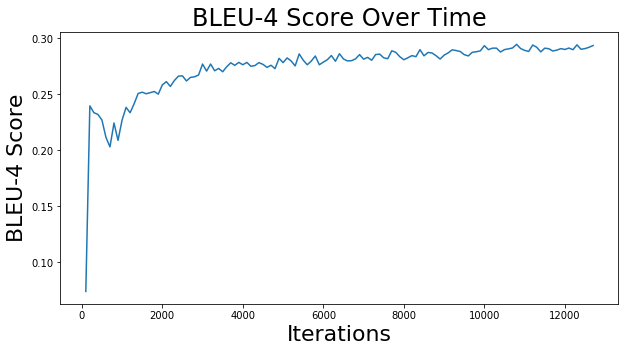

In [30]:
f = pylab.figure(figsize=(10,5))
pylab.plot(list(range(100,len(bleu_over_time)*100,100)), bleu_over_time[1:])
pylab.xlabel('Iterations', fontsize=22)
pylab.ylabel('BLEU-4 Score', fontsize=22)
pylab.title('BLEU-4 Score Over Time', fontsize =24)

## CONCLUSION

In this notebook, I tried to make an automated image caption generator with a reasonable accuracy. If you end up running this whole notebook on your machine, and if for some reason you're not able to see the images alongside the captions in the last cell, please go up to see the initial images I loaded when checking if the VGG16 classifier was working properly. 

This model is still not perfect, but it's quite accurate! After 10000 steps, it's generating decent captions for the images, although it still confuses a couple of images. 
Another thing worth mentioning is that these are the results obtained using approximately only one third of the full training data available. Furthermore, I just used a simple single cell LSTM. In the future I'd like to try to maximize the performance by employing the full set of training data as well as using multilayered LSTMs (or GRUs) with better
regularization.

I worked really hard to make this code as modular and nicely commented as I could, although I can always do better.Please feel free to let me know if I missed something, or if I could make this code more efficient. 
Thanks for reading!!